In [3]:
import array
import random
import json

import numpy

from math import sqrt

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Problem definition
# Functions zdt1, zdt2, zdt3, zdt6 have bounds [0, 1]
BOUND_LOW, BOUND_UP = 0.0, 1.0

# Functions zdt4 has bounds x1 = [0, 1], xn = [-5, 5], with n = 2, ..., 10
# BOUND_LOW, BOUND_UP = [0.0] + [-5.0]*9, [1.0] + [5.0]*9

# Functions zdt1, zdt2, zdt3 have 30 dimensions, zdt4 and zdt6 have 10
NDIM = 30

def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", benchmarks.zdt1)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("select", tools.selNSGA2)

def main(seed=None):
    random.seed(seed)

    NGEN = 250
    MU = 100
    CXPB = 0.9

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    # stats.register("avg", numpy.mean, axis=0)
    # stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"

    pop = toolbox.population(n=MU)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))

    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    # Begin the generational process
    for gen in range(1, NGEN):
        # Vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)

            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Select the next generation population
        pop = toolbox.select(pop + offspring, MU)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream)

    print("Final population hypervolume is %f" % hypervolume(pop, [11.0, 11.0]))

    return pop, logbook

d:\VSCode Projects\airfoil-optimization-ga\.venv\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
d:\VSCode Projects\airfoil-optimization-ga\.venv\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [4]:
with open("data/pareto_front/zdt1_front.json") as optimal_front_data:
    optimal_front = json.load(optimal_front_data)
# Use 500 of the 1000 points in the json file
optimal_front = sorted(optimal_front[i] for i in range(0, len(optimal_front), 2))

pop, stats = main()
pop.sort(key=lambda x: x.fitness.values)

print(stats)
print("Convergence: ", convergence(pop, optimal_front))
print("Diversity: ", diversity(pop, optimal_front[0], optimal_front[-1]))

import matplotlib.pyplot as plt
import numpy

front = numpy.array([ind.fitness.values for ind in pop])
optimal_front = numpy.array(optimal_front)
plt.scatter(optimal_front[:,0], optimal_front[:,1], c="r")
plt.scatter(front[:,0], front[:,1], c="b")
plt.axis("tight")
plt.show()

SyntaxError: invalid syntax (3786632074.py, line 3)

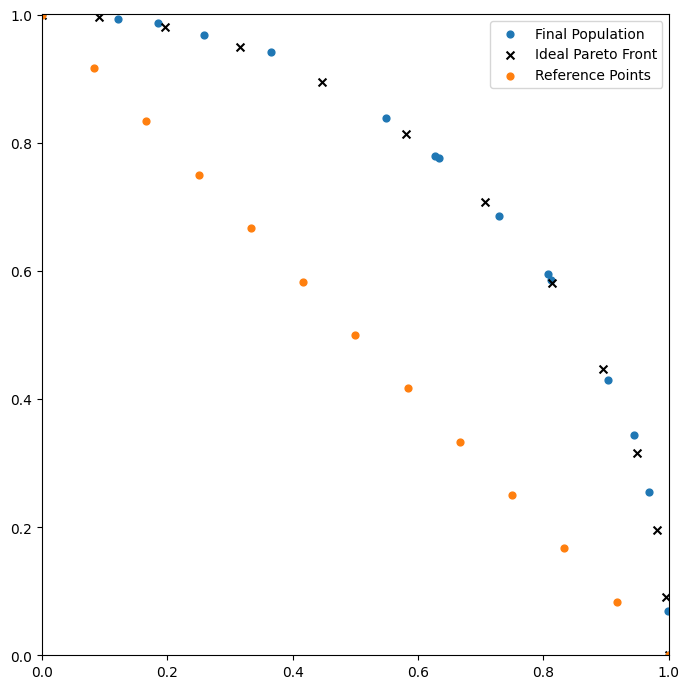

In [ ]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as Axes3d

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

p = numpy.array([ind.fitness.values for ind in pop])
ax.scatter(p[:, 0], p[:, 1], marker="o", s=24, label="Final Population")

ax.scatter(pf[:, 0], pf[:, 1],marker="x", c="k", s=32, label="Ideal Pareto Front")

ref_points = tools.uniform_reference_points(NOBJ, P)

ax.scatter(ref_points[:, 0], ref_points[:, 1], marker="o", s=24, label="Reference Points")

ax.autoscale(tight=True)
plt.legend()
plt.tight_layout()
plt.savefig("nsga3.png")